In [6]:
import numpy as np
import pandas as pd
import torch
import os, sys
sys.path.append(os.path.realpath('./src/'))

import time
import matplotlib.pyplot as plt
import matplotlib
from scipy.spatial import ConvexHull
from matplotlib.patches import Polygon, Ellipse
from smallestEllipse import *

from utilFuncs import to_np, to_torch
from materialEncoder import MaterialEncoder


import seaborn as sns
import scipy as sp

#matplotlib qt



In [ ]:
def preprocessData():
    # Load your data
    df = pd.read_excel('./computed_material_features_to_use.xlsx')

    # Keep track of 'family' only
    dataIdentifier = {'family': df['family']}

    # Select the properties you want to model (features)
    feature_columns = ['rho_eff', 'cost', 'energy', 'waste']
    trainInfo = np.log10(df[feature_columns].to_numpy())

    # Normalize to [0, 1]
    dataScaleMax = torch.tensor(np.max(trainInfo, axis=0))
    dataScaleMin = torch.tensor(np.min(trainInfo, axis=0))
    normalizedData = (torch.tensor(trainInfo) - dataScaleMin) / (dataScaleMax - dataScaleMin)
    trainingData = normalizedData.clone().float()

    # Create dataInfo for reference
    dataInfo = {
        'rho_eff': {'idx': 0, 'scaleMin': dataScaleMin[0], 'scaleMax': dataScaleMax[0]},
        'cost':    {'idx': 1, 'scaleMin': dataScaleMin[1], 'scaleMax': dataScaleMax[1]},
        'energy':  {'idx': 2, 'scaleMin': dataScaleMin[2], 'scaleMax': dataScaleMax[2]},
        'waste':   {'idx': 3, 'scaleMin': dataScaleMin[3], 'scaleMax': dataScaleMax[3]},
    }

    return trainingData, dataInfo, dataIdentifier, trainInfo
trainingData, dataInfo, dataIdentifier, trainInfo = preprocessData()
numMaterialsInTrainingData, numFeatures = trainingData.shape


In [8]:
latentDim, hiddenDim = 2, 250
numEpochs = 40000
klFactor = 4.5e-5
learningRate = 2e-3
savedNet = './data/vaeNet.nt'
vaeSettings = {'encoder':{'inputDim':numFeatures, 'hiddenDim':hiddenDim,\
                                          'latentDim':latentDim},\
               'decoder':{'latentDim':latentDim, 'hiddenDim':hiddenDim,\
                                          'outputDim':numFeatures}}
materialEncoder = MaterialEncoder(trainingData, dataInfo, dataIdentifier, vaeSettings)
start = time.perf_counter()
convgHistory = materialEncoder.trainAutoencoder(numEpochs, klFactor, savedNet, learningRate)
print('training time : {:.2F} '.format(time.perf_counter() - start))

cpu
Iter 0 reconLoss 1.13E+03 klLoss 4.78E-01 loss 1.13E+03
Iter 500 reconLoss 9.75E+00 klLoss 2.73E+00 loss 1.25E+01
Iter 1000 reconLoss 9.12E+00 klLoss 2.41E+00 loss 1.15E+01
Iter 1500 reconLoss 8.72E+00 klLoss 2.28E+00 loss 1.10E+01
Iter 2000 reconLoss 8.52E+00 klLoss 2.21E+00 loss 1.07E+01
Iter 2500 reconLoss 8.44E+00 klLoss 2.18E+00 loss 1.06E+01
Iter 3000 reconLoss 8.29E+00 klLoss 2.15E+00 loss 1.04E+01
Iter 3500 reconLoss 8.17E+00 klLoss 2.13E+00 loss 1.03E+01
Iter 4000 reconLoss 8.05E+00 klLoss 2.12E+00 loss 1.02E+01
Iter 4500 reconLoss 8.16E+00 klLoss 2.11E+00 loss 1.03E+01
Iter 5000 reconLoss 7.85E+00 klLoss 2.11E+00 loss 9.96E+00
Iter 5500 reconLoss 7.84E+00 klLoss 2.10E+00 loss 9.94E+00
Iter 6000 reconLoss 7.61E+00 klLoss 2.11E+00 loss 9.73E+00
Iter 6500 reconLoss 7.46E+00 klLoss 2.12E+00 loss 9.58E+00
Iter 7000 reconLoss 7.34E+00 klLoss 2.12E+00 loss 9.47E+00
Iter 7500 reconLoss 7.52E+00 klLoss 2.13E+00 loss 9.65E+00
Iter 8000 reconLoss 7.29E+00 klLoss 2.12E+00 loss 9.41E+

In [7]:
plt.close('all')


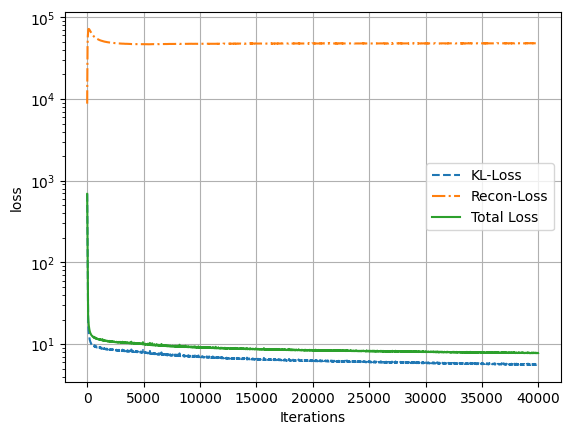

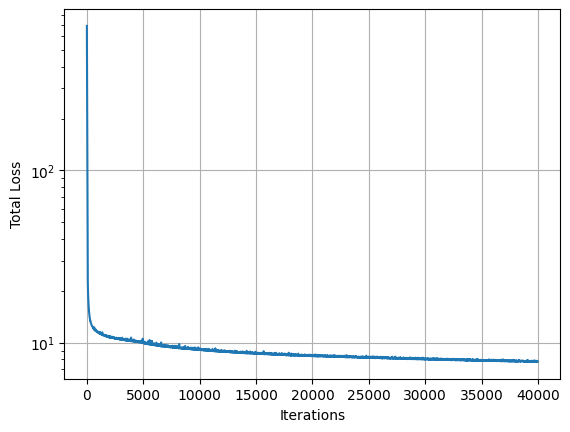

In [10]:
def plotConvergence(convg):
  plt.figure()
  strokes = ['--', '-.', '-', ':']
  for ctr, key in enumerate(convg):
    y = torch.as_tensor(convg[key]).detach().numpy()
    y_mvavg = np.convolve(y, np.ones(20), 'valid') / 20.
    plt.semilogy(y_mvavg, strokes[ctr], label = str(key))
    plt.xlabel('Iterations')
    plt.ylabel(str(key))
    plt.grid('True')
    plt.legend(labels={'KL-Loss','Recon-Loss','Total Loss'})
    # plt.legend('ReconLoss','KL-Loss','TotalLoss')
    plt.savefig('./figures/convergence.pdf',bbox_inches='tight')

plotConvergence(convgHistory)


def plotLoss(convg):
  plt.figure()
  y = torch.as_tensor(convg['loss']).detach().numpy()
  y_mvavg = np.convolve(y, np.ones(20), 'valid') / 20.
  plt.semilogy(y_mvavg, '-', label = 'Total Loss')
  plt.xlabel('Iterations')
  plt.ylabel('Total Loss')
  plt.grid('True')
  # plt.legend(labels={'Total Loss'})

plotLoss(convgHistory)



In [11]:
matidxs = np.arange(trainInfo.shape[0]).astype(int)#0,11,20,46,54,69,91,5,92]
props = ['UltimateStrength','YieldStress','MassDensity','CostPerPound','MeltingTempC','MaxUseTempC','Elong2Fail','ElasticModulus','CriticalityIdx']
print([dataIdentifier['name'][i] for i in matidxs])
print('\t \t ------TRUE DATA----------')
print('material name', end = '\t')


def unnormalize(val, minval ,maxval):
  return 10.**(minval + (maxval-minval)*val)
def decodeAll():
  vae = materialEncoder.vaeNet
  decoded = vae.decoder(vae.encoder.z)
  matProp = {'UltimateStrength':None,'YieldStress':None,\
             'MassDensity':None,'CostPerPound':None,'MeltingTempC':None,\
              'MaxUseTempC':None,'Elong2Fail':None,'ElasticModulus':None,'CriticalityIdx':None}
  for k in props:
    idx = materialEncoder.dataInfo[k]['idx']
    scaleMax = materialEncoder.dataInfo[k]['scaleMax']
    scaleMin = materialEncoder.dataInfo[k]['scaleMin']
    matProp[k] = unnormalize(decoded[:,idx], scaleMin ,scaleMax)#scaleMin + decoded[:,idx]*(scaleMax - scaleMin)
  return matProp

matProp = decodeAll()


merr = -1000000000.
maxError = {'UltimateStrength':merr,'YieldStress':merr,\
             'MassDensity':merr,'CostPerPound':merr,'MeltingTempC':merr,\
              'MaxUseTempC':merr,'Elong2Fail':merr,'ElasticModulus':merr,'CriticalityIdx':merr}
print('\n \n \t \t ------RECON ERROR (%)----------') 
print('material name', end = '\t')
for p in props:
    print(p, end = '\t')
for i in range(trainInfo.shape[0]):

  for p in props:
    idx = materialEncoder.dataInfo[p]['idx']
    trueData = 10**trainInfo[i,idx]
    reconData = matProp[p][i]
    err = torch.abs(100.*(trueData - reconData)/trueData)
    if(err > maxError[p]):
      maxError[p] = err



print('\n \t -----MAX Error %----- \t ', end = '\n')
for p in props:
    print(p, end = '\t')
    print('\t {:.1F} \t'.format(maxError[p]), end='\n')



['MAR M247', 'IN 100', 'Inconel 718', 'Inconel 625', 'Ultimet (r)', 'Nickel Alloy 263', 'Hastelloy 276', 'Hastelloy C-4', 'Incoloy 27-7MO', 'Incoloy 825', 'Haynes 214', '17-4PH SS', 'Grade 304 SS', 'Nitronic 60', 'Ti-10%V-2%Fe-3%Al', 'Ti-6%Al-4%V', 'Ti Grade 4', '7068 Al', '7075 Al', '6061 Al']
	 	 ------TRUE DATA----------
material name	
 
 	 	 ------RECON ERROR (%)----------
material name	UltimateStrength	YieldStress	MassDensity	CostPerPound	MeltingTempC	MaxUseTempC	Elong2Fail	ElasticModulus	CriticalityIdx	
 	 -----MAX Error %----- 	 
UltimateStrength		 1.3 	
YieldStress		 1.2 	
MassDensity		 0.6 	
CostPerPound		 1.4 	
MeltingTempC		 0.5 	
MaxUseTempC		 2.5 	
Elong2Fail		 2.8 	
ElasticModulus		 1.5 	
CriticalityIdx		 5.5 	


In [13]:
merr = torch.tensor([0.])
meanError = {'UltimateStrength':merr,'YieldStress':merr,\
             'MassDensity':merr,'CostPerPound':merr,'MeltingTempC':merr,\
              'MaxUseTempC':merr,'Elong2Fail':merr,'ElasticModulus':merr,'CriticalityIdx':merr}

for i in range(trainInfo.shape[0]):
  # if(i in matidxs): #
  #   print(f"\n {dataIdentifier['name'][i]} \t ", end = '')
  for p in props:
    idx = materialEncoder.dataInfo[p]['idx']
    trueData = 10**trainInfo[i,idx]
    reconData = matProp[p][i]
    err = torch.abs(100.*(trueData - reconData)/trueData).cpu()
    err = err.reshape((1,) + err.shape)
    meanError[p] = torch.cat((meanError[p],err),0)
    # meanError[p] = torch.cat([meanError[p],err],0)

print('\n \t -----Mean Error %----- \t ', end = '\n')
for p in props:
    print(p, end = '\t')
    print('\t {:.1F} \t'.format(torch.mean(meanError[p])), end='\n')


 	 -----Mean Error %----- 	 
UltimateStrength		 0.3 	
YieldStress		 0.5 	
MassDensity		 0.2 	
CostPerPound		 0.3 	
MeltingTempC		 0.1 	
MaxUseTempC		 0.5 	
Elong2Fail		 0.7 	
ElasticModulus		 0.2 	
CriticalityIdx		 1.8 	


In [ ]:
def plotLatent(ltnt1, ltnt2, plotHull, plotEllipse, annotateHead, saveFileName):
    clrs = ['purple', 'blue', 'red', 'teal', 'black', 'magenta', 'olive']
    mrkrSet = ['x','D','s','p','*','o','P']
    colorcol = dataIdentifier['classID']
    ptLabel = dataIdentifier['name']
    autoencoder = materialEncoder.vaeNet
    z = autoencoder.encoder.z.to('cpu').detach().numpy()
    fig, ax = plt.subplots()
    # matidxs = np.array([13,14,15,48,18,10,9,8,24,20,30,69,27,37,5,6,73,77,78,85,91,88,75,80,82]).astype(int)-2
    matidxs = np.arange(trainInfo.shape[0]).astype(int)
    for i in range(np.max(colorcol)+1): 
      zMat = np.vstack((z[colorcol == i,ltnt1], z[colorcol == i,ltnt2])).T
      ax.scatter(zMat[:, 0], zMat[:, 1], marker=mrkrSet[i], c = clrs[i], s = 12)#clrs[i]

      if(plotHull):
        hull = ConvexHull(zMat)
        cent = np.mean(zMat, 0)
        pts = []
        for pt in zMat[hull.simplices]:
            pts.append(pt[0].tolist())
            pts.append(pt[1].tolist())
  
        pts.sort(key=lambda p: np.arctan2(p[1] - cent[1],
                                        p[0] - cent[0]))
        pts = pts[0::2]  # Deleting duplicates
        pts.insert(len(pts), pts[0])
        # print(pts)
        poly = Polygon(1.1*(np.array(pts)- cent) + cent,
                       facecolor= clrs[i], alpha=0.2, edgecolor = 'black') #'black'
        poly.set_capstyle('round')
        plt.gca().add_patch(poly)
        # ax.annotate(dataIdentifier['className'][i], (cent[0], cent[1]), size = 15, c = 'red')
        # print(dataIdentifier['className'][i])

      if(plotEllipse):
        hull = ConvexHull(zMat)
        cent = np.mean(zMat, 0) + np.array([0,-0.5])
        pts = []
        for pt in zMat[hull.simplices]:
            pts.append(pt[0].tolist())
            pts.append(pt[1].tolist())
  
        pts.sort(key=lambda p: np.arctan2(p[1] - cent[1],
                                        p[0] - cent[0]))
        pts = pts[0::2]  # Deleting duplicates
        # pts.insert(len(pts), pts[0])
        enclosing_ellipse = welzl(np.array(pts, dtype=float))
        # plot resulting ellipse
        center,a,b,t = enclosing_ellipse
        elli = plot_ellipse(enclosing_ellipse, str='k')
        ellipse = Ellipse(xy=center, width=2*a, height=2*b, angle=np.degrees(t), edgecolor='k', fc=clrs[i], alpha=0.3, lw=2)
        ax.add_patch(ellipse)
        # ax.annotate(dataIdentifier['className'][i], (cent[0], cent[1]), size = 15, c = 'black')

        plt.show()

        # poly = Polygon(1.1*(np.array(pts)- cent) + cent,
        #                facecolor= clrs[i], alpha=0.2, edgecolor = 'black') #'black'
        # poly.set_capstyle('round')

        # plt.gca().add_patch(poly)
        # ax.annotate(dataIdentifier['className'][i], (cent[0], cent[1]), size = 15, c = 'red')
        # print(dataIdentifier['className'][i])
        # print(i)
    
    
    ax.annotate('Ti Alloys', xy=(-2, 0.8), xytext=(-2,0.8), size = 20, c = 'black', xycoords='data',textcoords='data')
    ax.annotate('Ni Alloys', xy=(-2, -2.7) ,xytext=(-2,-2.7), size = 20, c = 'black' ,xycoords='data',textcoords='data')
    ax.annotate('Steels', xytext=(2.1,-0.8), xy=(1.5, -0.5),size = 20, c = 'black', xycoords='data',textcoords='data')
    ax.annotate('Al Alloys', xytext=(2,0.8), xy=(1.5, 0.5),size = 20, c = 'black', xycoords='data',textcoords='data')

    
    # matidxs = [] 
    for i, txt in enumerate(ptLabel):
      if(annotateHead == False or ( annotateHead == True and  i in matidxs)):
        
        ax.annotate(txt, (z[i,ltnt1], z[i,ltnt2]), size = 10, style='normal',c='green')
        ax.scatter(z[i,ltnt1], z[i,ltnt2], marker='*', c = 'black', s = 56)

  #   plt.axis('off')
    ticks = [-3, -2,  -1., 0.,  1., 2, 3]
    ticklabels = ['-3','-2', '-1', '0','1', '2','3']
    plt.xticks(ticks, ticklabels, fontsize=18)
    plt.yticks(ticks, ticklabels, fontsize=18)
    plt.xlabel('$z_0$'.format(ltnt1), size = 18)
    plt.ylabel('$z_1$'.format(ltnt2), size = 18)
    # plt.title('Latent Space Representation')
    minor_ticks = np.arange(-3, 3, 0.1)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(minor_ticks, minor=True)
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_aspect('equal', 'box')
    # ax.patch.set_edgecolor('black')  
    # ax.patch.set_linewidth('1')  

    # plt.grid(which='minor')
    plt.grid(visible=None)
    plt.savefig(saveFileName,bbox_inches='tight')
    
    return fig, ax

plotLatent(0, 1, plotHull = False, plotEllipse = True, annotateHead = True, saveFileName = './figures/latent.pdf')

In [ ]:
plt.close('all')

In [ ]:
def plotLatentWithPropertyNew(ltnt1 = 0, ltnt2 = 1):
  n = 80
  zmin, zmax = -3,3
  X,Y = np.meshgrid(np.linspace(zmin, zmax, n), np.linspace(zmin, zmax, n))
  Z = torch.zeros((n**2, vaeSettings['encoder']['latentDim'])).to('cpu')
  Z[:,ltnt1], Z[:,ltnt2] = to_torch(X.reshape(-1)), to_torch(Y.reshape(-1))

  vae = materialEncoder.vaeNet.to('cpu')
  trainData_z_np = to_np(vae.encoder.z)
  decoded = vae.decoder(Z)



  #-------------------------------------------#
  props = ['YieldStress']
  cutOff = [2.5,5]; 
  for p in props:
    idx = materialEncoder.dataInfo[p]['idx']
    scaleMax = materialEncoder.dataInfo[p]['scaleMax']
    scaleMin = materialEncoder.dataInfo[p]['scaleMin']

    matPropVal = 10.**(scaleMin + decoded[:,idx]*(scaleMax - scaleMin))

    fig, ax =plotLatent(0, 1, plotHull = False, plotEllipse = True, annotateHead = True, saveFileName = './figures/latent.pdf')
    # surf = ax.contourf(X, Y, (to_np(matPropVal).reshape((n,n))), levels = 20, cmap='coolwarm', alpha = 0.0)
    surf = ax.contour(X, Y, (to_np(matPropVal).reshape((n,n))), levels = 15, cmap='coolwarm', alpha = 0.8)
    
    # surf = ax.contourf(X, Y, (to_np(matPropVal).reshape((n,n))), levels = cutOff, alpha = 0.3,\
    # colors=['g', 'g'], extend='both')
    # surf.cmap.set_over('white')
    # surf.cmap.set_under('white')
    # surf.changed()

    

    plt.clabel(surf, inline=False, fontsize=10, fmt ='%0.2f', colors = 'black')
    ax.set_xlabel('$z_0$')
    ax.set_ylabel('$z_1$')
    ax.set_title(p+' Contour Plot')
    cbar = plt.colorbar(surf)
    cbar.set_label('({:s})'.format(str(p)+' in MPa'))
    plt.savefig('./figures/{:s}_latentField.pdf'.format(p), dpi=200, bbox_inches='tight')

  #-------------------------------------------#
  

plt.close('all')
plt.figure()
plotLatentWithPropertyNew()